In [1]:
!pip install easycolab
import easycolab as ec
ec.mount()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Opening directory /content/gdrive/My Drive/
Done!


In [0]:
import torch
from torch import nn
import torch.utils.data as torch_data
from torchvision import transforms
from torchvision import models
import torchvision
from tqdm import tqdm
import numpy as np
import os
import random
import PIL
import matplotlib.pyplot as plt
import time

In [0]:
class create_set(torch_data.Dataset):
    def __init__(self, path_X, path_y,transform=None):
        super(create_set, self).__init__()
        
        self.X=sorted(os.listdir(path_X))
        self.y=sorted(os.listdir(path_y))
        self.transform=transform
        self.path_X=path_X
        self.path_y=path_y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        X=PIL.Image.open(os.path.join(self.path_X,self.X[idx])).crop((0, 138, 768, 906.0)).resize((256,256)) 
        y=PIL.Image.open(os.path.join(self.path_y,self.y[idx])).crop((0, 138, 768, 906.0)).resize((256,256)) 
        if self.transform is not None:
            rand=np.random.randint(10**9)
            random.seed(rand)
            X=self.transform(X)
            random.seed(rand)
            y=self.transform(y)
        return X, y

In [0]:
train_set=create_set('./data/trainX/', './data/trainY/', transform=transforms.Compose([
        transforms.ToTensor()
        ]))

In [0]:
class create_set(torch_data.Dataset):
    def __init__(self, path_X, path_y,transform=None):
        super(create_set, self).__init__()       
        self.X=sorted(os.listdir(path_X))[0:3]
        self.y=sorted(os.listdir(path_y))[0:3]
        self.transform=transform
        self.path_X=path_X
        self.path_y=path_y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        X=PIL.Image.open(os.path.join(self.path_X,self.X[idx])).crop((0, 138, 768, 906.0)).resize((256,256)) 
        y=PIL.Image.open(os.path.join(self.path_y,self.y[idx])).crop((0, 138, 768, 906.0)).resize((256,256)) 
        if self.transform is not None:
            rand=np.random.randint(10**9)
            random.seed(rand)
            X=self.transform(X)
            random.seed(rand)
            y=self.transform(y)
        return X, y

In [0]:
test_set=create_set('./testX/', './testY/', 
                    transform=transforms.Compose([transforms.ToTensor()]))

In [0]:
train_loader = torch_data.DataLoader(train_set, batch_size=1, shuffle=True) 


In [0]:
test_loader = torch_data.DataLoader(test_set, batch_size=1, shuffle=False)

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [0]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1):
        return input.view(input.size(0), size, 256, 256)

class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
                        nn.Conv2d(3, 32, kernel_size=3, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(True),

                        nn.Conv2d(32, 64, kernel_size=3, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(True),


                        nn.Conv2d(64, 128, kernel_size=3, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(True),

                        nn.Conv2d(128, 256, kernel_size=3, padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(True),

                        nn.Conv2d(256, 256, kernel_size=3, padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(True)
        )
        
        self.decoder = nn.Sequential(

                      
                        nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(True),

                        nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(True),

                        nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
                        nn.ReLU(True),

                       
                        nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
                        nn.ReLU(True),
                        
                        nn.ConvTranspose2d(32, 3, kernel_size=3,padding=1),
                        nn.ReLU(True))

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [11]:
torch.cuda.is_available()

True

In [0]:


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

epochs = 32
autoencoder = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)


In [0]:
def train(epochs, net, criterion, optimizer, trainload, testloader, scheduler=None, verbose=True):
    start = time.time()
    net.to(device)
    best_val_loss = float('+inf')
    for epoch in range(epochs):
        running_loss = 0.0
        net.train()

        for i, (X, y) in enumerate(trainload):
            X = Variable(X).to(device)
            y=y.to(device)
            _, decoded = net(X)
            loss = criterion(decoded, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        running_loss_val = 0.0
        net.eval()
        for i, (X,y) in enumerate(testloader):
 
            X = Variable(X).to(device)
            y=y.to(device)
            _, decoded = net(X)
            val_loss = criterion(decoded, y)

            running_loss_val+=val_loss.item()
        if scheduler is not None:
            scheduler.step()
        freq = max(epochs//20,1)
        if verbose and epoch%freq==0:
            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, running_loss, running_loss_val))

        if val_loss < best_val_loss:
          best_val_loss = val_loss
          torch.save(net.state_dict(), 'best_model.pth')

    end = time.time()
    print(f"Time cost for training (in seconds): {end-start}")

In [14]:
train(epochs, autoencoder, criterion, optimizer, train_loader, test_loader,  scheduler=None, verbose=True)

Epoch 0/32 || Loss:  Train 5.6956 | Validation 0.0226
Epoch 1/32 || Loss:  Train 2.9240 | Validation 0.0236
Epoch 2/32 || Loss:  Train 2.3147 | Validation 0.0565
Epoch 3/32 || Loss:  Train 1.7969 | Validation 0.0331
Epoch 4/32 || Loss:  Train 0.8005 | Validation 0.0316
Epoch 5/32 || Loss:  Train 0.5805 | Validation 0.0269
Epoch 6/32 || Loss:  Train 0.4990 | Validation 0.0252
Epoch 7/32 || Loss:  Train 0.4904 | Validation 0.0266
Epoch 8/32 || Loss:  Train 0.4268 | Validation 0.0262
Epoch 9/32 || Loss:  Train 0.4423 | Validation 0.0219
Epoch 10/32 || Loss:  Train 0.5461 | Validation 0.0163
Epoch 11/32 || Loss:  Train 0.6364 | Validation 0.0303
Epoch 12/32 || Loss:  Train 0.4713 | Validation 0.0334
Epoch 13/32 || Loss:  Train 0.4772 | Validation 0.0303
Epoch 14/32 || Loss:  Train 0.4485 | Validation 0.0501
Epoch 15/32 || Loss:  Train 0.4182 | Validation 0.0375
Epoch 16/32 || Loss:  Train 0.4493 | Validation 0.0273
Epoch 17/32 || Loss:  Train 0.4324 | Validation 0.0315
Epoch 18/32 || Loss:

In [15]:
state_dict = torch.load('best_model.pth')
autoencoder.load_state_dict(state_dict)

<All keys matched successfully>

In [16]:
running_loss_val = 0.0
i = 0
reconstruction_time=[]
decoded_pics = []

with torch.no_grad():
    for (X,y) in test_loader:
        X = Variable(X).to(device)
        y=y.to(device)
        i += 1
        encoded= autoencoder.encoder(X)
        start=time.time()
        decoded = autoencoder.decoder(encoded)
        end=time.time()
        reconstruction_time.append(end-start)
        decoded_pics.append(decoded)
        loss_val = criterion(decoded, y)
        running_loss_val += loss_val.data
print(running_loss_val)

tensor(0.0178, device='cuda:0')


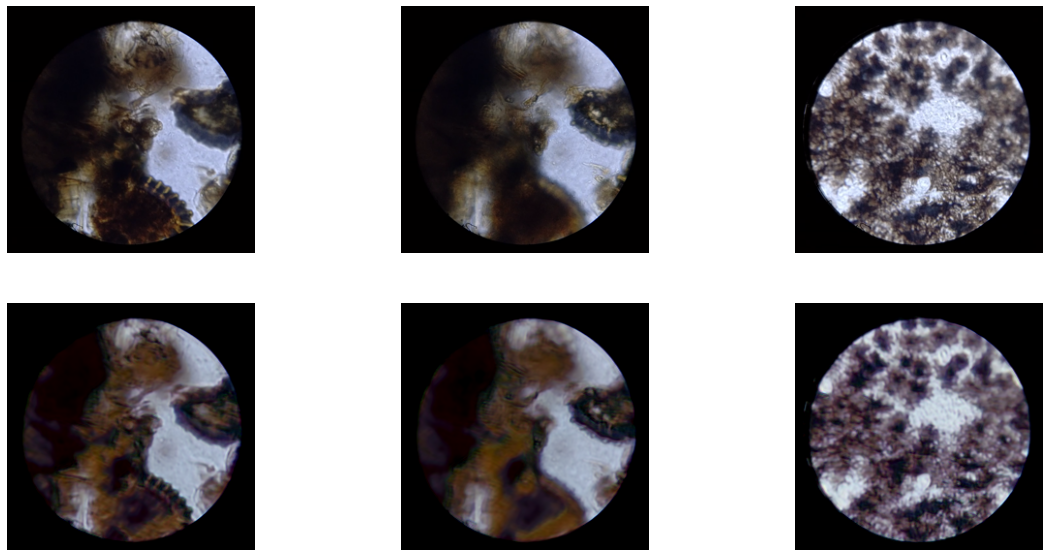

In [37]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))

for i, (X,y) in enumerate(test_loader):
    im = X
    ax[0, i].imshow(im.cpu().numpy().transpose([0, 2, 3, 1]).reshape(256, 256,3));
    ax[1, i].imshow(decoded_pics[i].cpu().numpy().transpose([0, 2, 3, 1]).reshape(256, 256,3))
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    if i==2:
      break



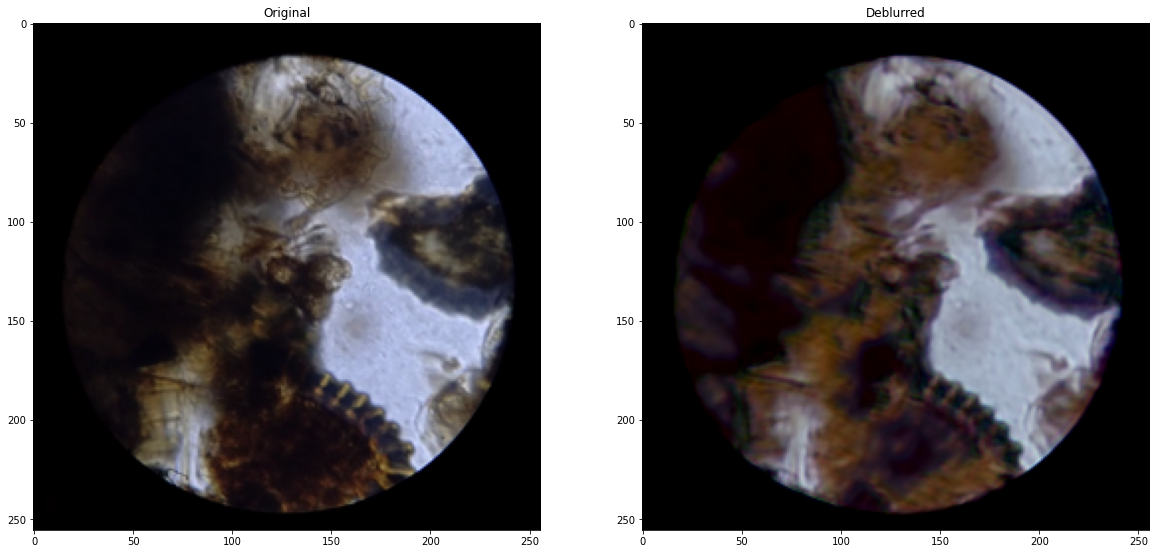

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


For decoded image: 11.204594485922767 0.3730109768555818
For initial image: 10.534274591785348 0.33508568465984334


In [38]:
from skimage import measure

plt.figure(figsize=(20,10))

for i, (X,y) in enumerate(test_loader):
  if i==0:
    plt.subplot(1,2,1)
    pic1=X.cpu().numpy().transpose([0, 2, 3, 1]).reshape(256, 256,3)
    plt.imshow(pic1);
    plt.title("Original")
    plt.subplot(1,2,2)
    pic2=decoded_pics[i].cpu().numpy().transpose([0, 2, 3, 1]).reshape(256, 256,3)
    plt.imshow(pic2)
    plt.title("Deblurred")
    plt.show()
    psnr_for_decoded=measure.compare_psnr(y.cpu().numpy().reshape(256, 256,3),pic2)
    ssim_for_decoded=measure.compare_ssim(y.cpu().numpy().reshape(256, 256,3),pic2,multichannel=True)
    print("For decoded image:", psnr_for_decoded, ssim_for_decoded)
    psnr_for_initial=measure.compare_psnr(y.cpu().numpy().reshape(256, 256,3),pic1)
    ssim_for_initial=measure.compare_ssim(y.cpu().numpy().reshape(256, 256,3),pic1,multichannel=True)
    print("For initial image:", psnr_for_initial, ssim_for_initial)
